# Calibration Tutorial - Crane, OR - Irrigated Flux Plot

## Step 1: Uncalibrated Model Run

This tutorial focuses on calibrating SWIM-RS for a single irrigated alfalfa plot at the S2 flux station in Crane, Oregon. Unlike the unirrigated Fort Peck example, this site is actively irrigated.

This notebook demonstrates:
1. Loading pre-built model input data
2. Running the uncalibrated SWIM model
3. Comparing model output with SSEBop ETf

**Input Data:** The `data/prepped_input.json` file contains pre-computed input data.

### Data Pipeline

The full data workflow uses two scripts and can be re-run if needed:

1. **`extract_data.py`** - Extracts raw data from Earth Engine and GridMET to CSV/parquet files
2. **`build_inputs.py`** - Processes extracted data through SwimContainer and exports to `prepped_input.json`

To reproduce the input data from scratch:

```bash
cd data
python extract_data.py    # Extract from EE/GridMET (requires authentication)
python build_inputs.py    # Build container and export JSON
```

See `data/extract_data.py` for extraction options and `data/build_inputs.py` for container workflow details.

In [1]:
import os
import sys
import time
import zipfile

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../..')
sys.path.append(root)

from swimrs.swim.config import ProjectConfig
from swimrs.swim.sampleplots import SamplePlots
from swimrs.model.obs_field_cycle import field_day_loop

from swimrs.viz.swim_timeseries import plot_swim_timeseries

%matplotlib inline

## 1. Project Setup

Define paths and unzip pre-built data if needed.

In [2]:
project_ws = os.path.abspath('.')
data = os.path.join(project_ws, 'data')

config_file = os.path.join(project_ws, '3_Crane.toml')
prepped_input = os.path.join(data, 'prepped_input.json')

# Unzip data files if they haven't been extracted
prepped_zip = os.path.join(data, 'prepped_input.zip')

if os.path.exists(prepped_zip) and not os.path.exists(prepped_input):
    print("Extracting prepped_input.zip...")
    with zipfile.ZipFile(prepped_zip, 'r') as z:
        z.extractall(data)

# Unzip flux tower data if needed
flux_zip = os.path.join(data, 'S2_daily_data.zip')
flux_csv = os.path.join(data, 'S2_daily_data.csv')

if os.path.exists(flux_zip) and not os.path.exists(flux_csv):
    print("Extracting S2_daily_data.zip...")
    with zipfile.ZipFile(flux_zip, 'r') as z:
        z.extractall(data)

print(f"Project workspace: {project_ws}")
print(f"Config file: {config_file}")
print(f"Input data: {prepped_input}")

Project workspace: /home/dgketchum/code/swim-rs/examples/3_Crane
Config file: /home/dgketchum/code/swim-rs/examples/3_Crane/3_Crane.toml
Input data: /home/dgketchum/code/swim-rs/examples/3_Crane/data/prepped_input.json


In [3]:
# Load the project configuration
config = ProjectConfig()
config.read_config(config_file, project_ws)

### Initial Parameter Values

The model will run with the following default parameter values and bounds:

In [4]:
from swimrs.calibrate.pest_builder import PestBuilder

def show_parameter_table(config):
    """Display parameter bounds and initial values from PestBuilder."""
    builder = PestBuilder(config)
    params = builder.initial_parameter_dict()
    
    print("=" * 80)
    print("INITIAL PARAMETER VALUES AND BOUNDS")
    print("=" * 80)
    print(f"{'Parameter':<12} {'Initial':>12} {'Lower':>10} {'Upper':>10} {'Std':>8}  Description")
    print("-" * 80)
    
    descriptions = {
        'aw': 'Available water capacity (mm)',
        'ks_alpha': 'Soil evap stress damping',
        'kr_alpha': 'Root zone stress damping', 
        'ndvi_k': 'NDVI-Kcb slope',
        'ndvi_0': 'NDVI-Kcb intercept',
        'mad': 'Management allowable depletion',
        'swe_alpha': 'Snow melt temp coefficient',
        'swe_beta': 'Snow melt rate coefficient',
    }
    
    for name, p in params.items():
        init = p['initial_value']
        if init is None:
            init_str = 'auto'
        elif isinstance(init, str):
            init_str = init[:12]
        else:
            init_str = f"{init:.2f}"
        print(f"{name:<12} {init_str:>12} {p['lower_bound']:>10.2f} {p['upper_bound']:>10.2f} {p['std']:>8.2f}  {descriptions.get(name, '')}")
    
    print("=" * 80)

show_parameter_table(config)

Using default Python script at: /home/dgketchum/code/swim-rs/src/swimrs/calibrate/custom_forward_run.py
INITIAL PARAMETER VALUES AND BOUNDS
Parameter         Initial      Lower      Upper      Std  Description
--------------------------------------------------------------------------------
aw                   auto     100.00     400.00    50.00  Available water capacity (mm)
ks_alpha             0.50       0.01       1.00     0.15  Soil evap stress damping
kr_alpha             0.50       0.01       1.00     0.15  Root zone stress damping
ndvi_k               7.00       4.00      10.00     0.75  NDVI-Kcb slope
ndvi_0               0.40       0.10       0.70     0.25  NDVI-Kcb intercept
mad                  auto       0.01       0.90     0.15  Management allowable depletion
swe_alpha            0.30      -0.50       1.00     0.20  Snow melt temp coefficient
swe_beta             1.50       0.50       2.50     0.30  Snow melt rate coefficient


/home/dgketchum/miniconda/envs/swim/lib/python3.11/site-packages/pyemu/__init__.py:37: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


## 2. About the Study Site

The S2 site is an irrigated alfalfa field in Crane, Oregon. According to IrrMapper data, this location has been irrigated since about 1996, making it a good test case for the irrigation scheduling component of SWIM-RS.

In [5]:
selected_feature = 'S2'

print(f"Site: {selected_feature}")
print(f"Location: Crane, Oregon")
print(f"Crop: Irrigated alfalfa")
print(f"Date range: {config.start_dt} to {config.end_dt}")

Site: S2
Location: Crane, Oregon
Crop: Irrigated alfalfa
Date range: 2003-01-01 00:00:00 to 2007-12-31 00:00:00


## 3. Run the Uncalibrated Model

We define a helper function to run the SWIM model and capture its output.

In [6]:
def run_fields(ini_path, project_ws, selected_feature, output_csv, forecast=False):
    """Run SWIM model and save combined input/output to CSV."""
    start_time = time.time()

    config = ProjectConfig()
    config.read_config(ini_path, project_ws, forecast=forecast)

    fields = SamplePlots()
    fields.initialize_plot_data(config)
    fields.output = field_day_loop(config, fields, debug_flag=True)

    end_time = time.time()
    print(f'\nExecution time: {end_time - start_time:.2f} seconds\n')

    out_df = fields.output[selected_feature].copy()
    in_df = fields.input_to_dataframe(selected_feature)
    
    # Drop columns from input that already exist in output to avoid duplicates
    overlap_cols = out_df.columns.intersection(in_df.columns)
    if len(overlap_cols) > 0:
        in_df = in_df.drop(columns=overlap_cols)
    
    df = pd.concat([out_df, in_df], axis=1, ignore_index=False)
    
    # Cut out nan output from before the start of the model run
    df = df.loc[config.start_dt:config.end_dt]
    
    df.to_csv(output_csv)
    return df

In [7]:
selected_feature = 'S2'
out_csv = os.path.join(project_ws, f'combined_output_{selected_feature}_uncalibrated.csv')

df = run_fields(config_file, project_ws, selected_feature=selected_feature, output_csv=out_csv)

USING PARAMETER DEFAULTS

Execution time: 1.35 seconds



In [8]:
print(f"Output shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nKey output columns:")
key_cols = ['et_act', 'etref', 'kc_act', 'kc_bas', 'ks', 'ke', 'melt', 'rain', 
            'depl_root', 'swe', 'ppt', 'irrigation', 'soil_water']
for col in key_cols:
    if col in df.columns:
        print(f"  {col}: mean={df[col].mean():.3f}, max={df[col].max():.3f}")

Output shape: (1826, 73)
Date range: 2003-01-01 00:00:00 to 2007-12-31 00:00:00

Key output columns:
  et_act: mean=1.643, max=6.797
  etref: mean=2.884, max=8.528
  kc_act: mean=0.585, max=0.963
  kc_bas: mean=0.426, max=0.967
  ks: mean=0.985, max=1.000
  ke: mean=0.334, max=0.698
  melt: mean=0.140, max=9.366
  rain: mean=0.586, max=25.900
  depl_root: mean=37.744, max=160.201
  swe: mean=1.541, max=59.716
  ppt: mean=0.736, max=25.900
  irrigation: mean=1.011, max=25.400
  soil_water: mean=252.115, max=336.000


## 4. Visualize Model Output

Let's examine a single year (2004) to see the model's behavior.

In [9]:
ydf = df.loc['2004-01-01': '2004-12-31']
print(f'Total irrigation: {ydf.irrigation.sum():.1f} mm')
print(f'Total ET: {ydf.et_act.sum():.1f} mm')
print(f'Total precipitation: {ydf.ppt.sum():.1f} mm')

plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'], 
                     start='2004-01-01', end='2004-12-31', png_dir='et_uncalibrated.png')

Total irrigation: 286.4 mm
Total ET: 555.7 mm
Total precipitation: 267.7 mm
et_uncalibrated.png


## 5. Compare with Flux Tower Observations

Now we have three estimates of ET as a ratio of reference ET (ETf or Kc):

1. **SSEBop ETf**: Remote sensing retrievals on Landsat overpass dates
2. **SWIM Kc_act**: Model-estimated actual crop coefficient (analogous to ETf)
3. **Flux EToF**: Independent observations from the S2 eddy covariance tower (Volk et al.)

Let's compare the agreement between these estimates:

In [10]:
def compare_etf_estimates(combined_output_path, flux_data_path, irr=True):
    """Compare model Kc_act and SSEBop ETf against flux tower observations."""
    flux_data = pd.read_csv(flux_data_path, index_col='date', parse_dates=True)['EToF']

    output = pd.read_csv(combined_output_path, index_col=0)
    output.index = pd.to_datetime(output.index)

    etf = 'etf_irr' if irr else 'etf_inv_irr'

    comparison_df = pd.DataFrame({'kc_act': output['kc_act'],
                                  'etf': output[etf],
                                  'EToF': flux_data})

    # Filter for days that have both SSEBop ETf and flux observations
    # ETf is sparse (not interpolated), so dropna filters to capture dates
    comparison_df = comparison_df.dropna()

    if len(comparison_df) == 0:
        print("No overlapping data between model ETf and flux tower observations")
        return comparison_df

    # Calculate RMSE and R-squared
    rmse_kc_act = np.sqrt(mean_squared_error(comparison_df['EToF'], comparison_df['kc_act']))
    r2_kc_act = r2_score(comparison_df['EToF'], comparison_df['kc_act'])

    rmse_ssebop = np.sqrt(mean_squared_error(comparison_df['EToF'], comparison_df['etf']))
    r2_ssebop = r2_score(comparison_df['EToF'], comparison_df['etf'])

    print(f"Comparison with {len(comparison_df)} overlapping observations:")
    print(f"SWIM Kc_act vs. Flux EToF: RMSE = {rmse_kc_act:.2f}, R-squared = {r2_kc_act:.2f}")
    print(f"SSEBop ETf vs. Flux EToF: RMSE = {rmse_ssebop:.2f}, R-squared = {r2_ssebop:.2f}")

    return comparison_df

In [11]:
# Use irrigated mask since this is an irrigated site
flux_data = os.path.join(data, 'S2_daily_data.csv')
comparison_df = compare_etf_estimates(out_csv, flux_data, irr=True)

No overlapping data between model ETf and flux tower observations


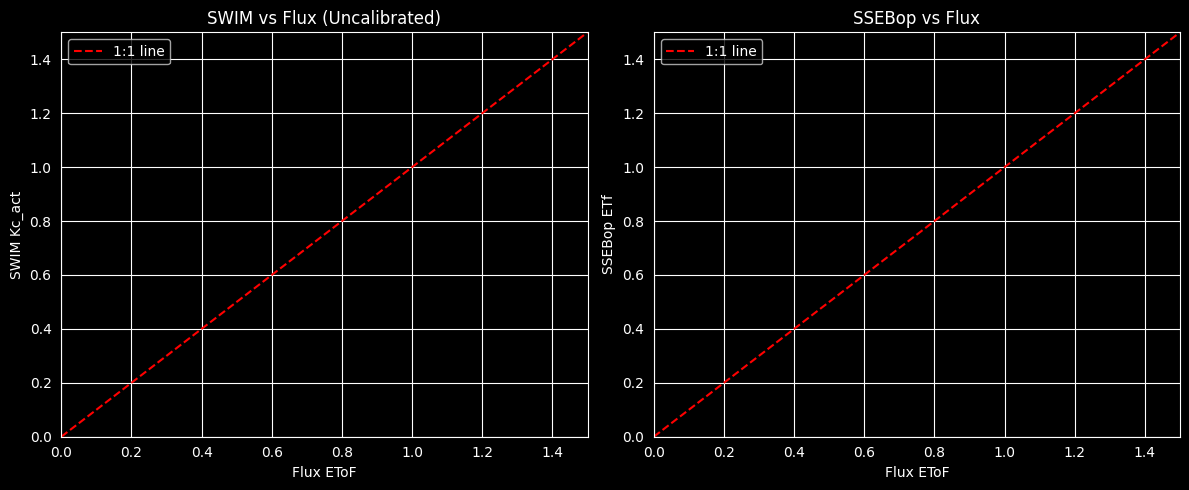

In [12]:
import matplotlib.pyplot as plt

# Create a scatter plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.scatter(comparison_df['EToF'], comparison_df['kc_act'], alpha=0.5, s=10)
ax1.plot([0, 1.5], [0, 1.5], 'r--', label='1:1 line')
ax1.set_xlabel('Flux EToF')
ax1.set_ylabel('SWIM Kc_act')
ax1.set_title('SWIM vs Flux (Uncalibrated)')
ax1.legend()
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0, 1.5)

ax2 = axes[1]
ax2.scatter(comparison_df['EToF'], comparison_df['etf'], alpha=0.5, s=10)
ax2.plot([0, 1.5], [0, 1.5], 'r--', label='1:1 line')
ax2.set_xlabel('Flux EToF')
ax2.set_ylabel('SSEBop ETf')
ax2.set_title('SSEBop vs Flux')
ax2.legend()
ax2.set_xlim(0, 1.5)
ax2.set_ylim(0, 1.5)

plt.tight_layout()
plt.savefig('comparison_scatter_uncalibrated.png', dpi=150)
plt.show()

## Summary

The uncalibrated model using default parameters shows the baseline performance before calibration. We compared both SWIM and SSEBop against independent flux tower observations.

**Key observations:**
- The model isn't applying enough irrigation
- The NDVI-to-Kcb relationship needs tuning for alfalfa
- Soil parameters may not match the actual site conditions

**Next step:** In notebook `02_calibration.ipynb`, we'll use PEST++ to calibrate the model parameters using SSEBop ETf and SNODAS SWE observations.

**Key insight:** We're not using the flux data for calibration - it's only for validation. For calibration, we rely solely on widely-available remote sensing data (SSEBop ETf and SNODAS SWE).

## Optional: Query Data from SwimContainer

If you've built the container using `build_inputs.py`, you can query ingested data directly:

In [13]:
# Query container data (optional - requires build_inputs.py to have been run)
from swimrs.container import SwimContainer

container_path = os.path.join(data, '3_Crane.swim')

if os.path.exists(container_path):
    container = SwimContainer.open(container_path, mode='r')
    
    # List available fields
    print(f"Fields in container: {container.field_uids}")
    
    # Get all time series for a single field using field_timeseries
    ts_df = container.query.field_timeseries('S2')
    print(f"\nTime series shape: {ts_df.shape}")
    print(f"Variables: {list(ts_df.columns)[:10]}...")
    
    # Query specific data using dataframe with zarr paths
    # Path structure: remote_sensing/{type}/{instrument}/{model}/{mask}
    ndvi_df = container.query.dataframe("remote_sensing/ndvi/landsat/irr", fields=['S2'])
    print(f"\nNDVI observations: {ndvi_df.notna().sum().values[0]}")
    
    etf_df = container.query.dataframe("remote_sensing/etf/landsat/ssebop/irr", fields=['S2'])
    print(f"ETf observations: {etf_df.notna().sum().values[0]}")
    
    # Show container status
    print("\n" + container.query.status())
    
    container.close()
else:
    print(f"Container not found at {container_path}")
    print("Run: cd data && python build_inputs.py")

Fields in container: ['S2']

Time series shape: (1826, 18)
Variables: ['meteorology_gridmet_etr_corr', 'meteorology_gridmet_ea', 'meteorology_gridmet_u2', 'meteorology_gridmet_eto_corr', 'meteorology_gridmet_tmax', 'meteorology_gridmet_eto', 'meteorology_gridmet_prcp', 'meteorology_gridmet_tmin', 'meteorology_gridmet_srad', 'meteorology_gridmet_etr']...

NDVI observations: 105
ETf observations: 97

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/3_Crane/data/3_Crane.swim
  Storage: directory
  Fields: 1
  Date range: 2003-01-01 to 2007-12-31
  Days: 1826

DATA PATHS:
----------------------------------------

  derived/
    dynamics/gwsub_data: shape=(1,), 100.0% non-empty
    dynamics/irr_data: shape=(1,), 100.0% non-empty
    dynamics/kc_max: shape=(1,), 100.0% valid
    dynamics/ke_max: shape=(1,), 100.0% valid
    merged_ndvi/inv_irr: shape=(1826, 1), 1.2% valid
    merged_ndvi/irr: shape=(1826, 1), 5.8% valid

  geometry/
    area_m2: shape=(1,), 100.0% valid
 